In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np

In [4]:
import sys
import os
from collections import defaultdict, Counter

In [5]:
import math

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt 

## Constants

In [7]:
data_path = "/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability"

## Get paths of files

In [8]:
base_file_dict = defaultdict(list)
tax_registry_b_1_file_dict = defaultdict(list)
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        if file_path.endswith('parquet'):
            file_type = 'train' if 'train' in file_path else 'test'
            if 'base' in file_path:
                base_file_dict[file_type].append(file_path)
            if 'tax_registry_b_1' in file_path:
                tax_registry_b_1_file_dict[file_type].append(file_path)

In [9]:
tax_registry_b_1_file_dict.get("train")

['/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability/parquet_files/train/train_tax_registry_b_1.parquet']

## Functions

In [10]:
def get_column_description(feature_def_df, column_name):
    return feature_def_df[feature_def_df.Variable == column_name]['Description'].iloc[0]

In [11]:
def plot_scatterplot(df, x_col_name, y_col_name, show_x_y_line=False):
    assert x_col_name in df.columns, f"Ensure that {x_col_name} is in the df"
    assert y_col_name in df.columns, f"Ensure that {y_col_name} is in the df"
    
    fig, axs = plt.subplots()
    sns.scatterplot(data=df, x=df[x_col_name], y=df[y_col_name], ax=axs)
    
    if show_x_y_line:
        df[x_col_name] = df[x_col_name].replace([np.inf, -np.inf], np.nan)
        df[y_col_name] = df[y_col_name].replace([np.inf, -np.inf], np.nan)
        not_null_x_filter = ~df[x_col_name].isnull()
        not_null_y_filter = ~df[y_col_name].isnull()
        not_null_filter = not_null_x_filter & not_null_y_filter
        filtered_df = df[not_null_filter]
        x_values_series = filtered_df[x_col_name]
        y_values_series = filtered_df[y_col_name]
        x0, x1 = min(x_values_series), max(x_values_series)
        y0, y1 = min(y_values_series), max(y_values_series)
        #line_values = [i for i in np.arange(min(x0, y0), max(x1, y1), 0.1)]
        lims = [min(x0, y0), max(x1, y1)]
        print(f"lims: {lims}")
        plt.plot(lims, lims)
    return fig

In [12]:
def get_percent_of_column(df, groupby_column, target_column):
    target_df = df.groupby(by=[groupby_column]).agg({target_column:"sum"}).reset_index()
    all_rows_df = df.groupby(by=[groupby_column]).size().reset_index().rename({0:"total_rows"}, axis=1)
    merged_df = target_df.merge(all_rows_df, left_on=[groupby_column], right_on=[groupby_column], how="left")
    merged_df["percentage_default"] = 100*merged_df["target"]/merged_df["total_rows"]
    merged_df[groupby_column] = merged_df[groupby_column].astype(str)
    return merged_df

In [13]:
def plot_barplot(df, percent_column, category_column):
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    sns.barplot(ax=ax, data=df, y=category_column, x=percent_column, order=df.sort_values(by=[percent_column], ascending=False)[category_column].values)
    return fig

In [14]:
def get_relevant_indices(series):
    percentile_25 = series.quantile(0.25)
    percentile_75 = series.quantile(0.75)
    iqr = percentile_75-percentile_25
    upper_limit = percentile_75 + 1.5*iqr
    lower_limit = percentile_25 - 1.5*iqr

    keep_indices = series[(series>=lower_limit) & (series<=upper_limit)].index
    return keep_indices 

## Read datasets

In [15]:
feature_df = pd.read_csv(f"{data_path}/feature_definitions.csv")
print(f"Shape of feature_df: {feature_df.shape}")

Shape of feature_df: (465, 2)


In [16]:
train_base_df = pd.concat([pd.read_parquet(file_path) for file_path in base_file_dict['train']], axis=0)
print(f"Shape of train_base_df: {train_base_df.shape}")

Shape of train_base_df: (1526659, 5)


## Properties: depth=1, internal data source

In [17]:
tax_registry_b_1_df = pd.concat([pd.read_parquet(file_path) for file_path in tax_registry_b_1_file_dict['train']], axis=0)
print(f"Shape of tax_registry_b_1_df: {tax_registry_b_1_df.shape}")

Shape of tax_registry_b_1_df: (1107933, 5)


In [18]:
tax_registry_b_1_df.columns.unique()

Index(['case_id', 'amount_4917619A', 'deductiondate_4917603D', 'name_4917606M',
       'num_group1'],
      dtype='object')

In [19]:
train_base_df["date_decision"] = pd.to_datetime(train_base_df["date_decision"])

tax_registry_b_1_df["deductiondate_4917603D"] = pd.to_datetime(tax_registry_b_1_df["deductiondate_4917603D"])

## This means that there are multiple rows for each case_id indexed by num_group1

In [20]:
unique_num_group_case_id_df = tax_registry_b_1_df.groupby(by=["case_id"]).agg({"num_group1": "nunique"}).reset_index().rename({"num_group1": "generated_count_of_tax_information_by_provider_b"}, axis=1)

In [21]:
unique_num_group_case_id_df[unique_num_group_case_id_df.generated_count_of_tax_information_by_provider_b>10].sort_values(by=["generated_count_of_tax_information_by_provider_b"]).head(5)

,case_id,generated_count_of_tax_information_by_provider_b
0,49435,11
70263,1846104,11
70241,1846077,11
70220,1846049,11
70193,1846015,11


In [22]:
tax_registry_b_1_df[tax_registry_b_1_df.case_id == 1846104].sort_values(by=["num_group1"]).head()

,case_id,amount_4917619A,deductiondate_4917603D,name_4917606M,num_group1
506885,1846104,4474.4,2019-12-09,2ddf7c32,0
506880,1846104,2601.8,2019-12-09,2ddf7c32,1
506881,1846104,2601.8,2019-12-25,2ddf7c32,2
506886,1846104,4474.4,2019-12-25,2ddf7c32,3
506887,1846104,4474.4,2020-02-10,2ddf7c32,4


<Axes: ylabel='generated_count_of_tax_information_by_provider_b'>

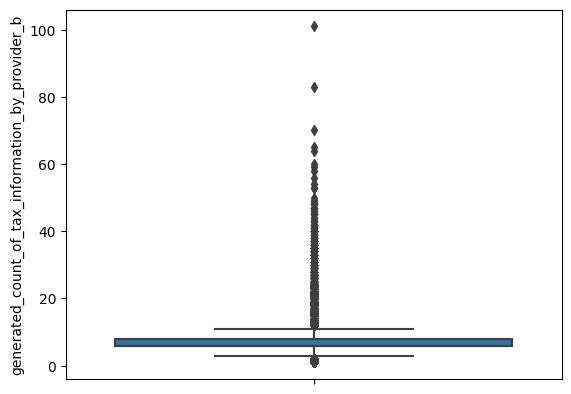

In [23]:
sns.boxplot(data=unique_num_group_case_id_df, y="generated_count_of_tax_information_by_provider_b")

## Number of tax related records provided for case_ids vary from 1 to 99

### 1. deductiondate_4917603D

In [24]:
get_column_description(feature_df, "deductiondate_4917603D")

'Tax deduction date.'

In [25]:
tax_registry_b_1_df.deductiondate_4917603D.isnull().value_counts()

deductiondate_4917603D
False    1107933
Name: count, dtype: int64

In [26]:
## Check across how unique dates are tax deduction records for a given case_id
statistics_deductiondate_4917603D_for_case_id_df = tax_registry_b_1_df.groupby(by=["case_id"]).agg({"deductiondate_4917603D": ["nunique", "max"]}).reset_index()
statistics_deductiondate_4917603D_for_case_id_df.columns  = ['case_id' if index_tuple[0] == 'case_id' else f"generated_{index_tuple[0]}_{index_tuple[1]}" for index_tuple in statistics_deductiondate_4917603D_for_case_id_df.columns]

In [27]:
statistics_deductiondate_4917603D_for_case_id_df.head(2)

,case_id,generated_deductiondate_4917603D_nunique,generated_deductiondate_4917603D_max
0,49435,2,2020-03-24
1,49490,6,2020-03-10


In [28]:
print(f"Minimum number of unique dates associated with case_id: {statistics_deductiondate_4917603D_for_case_id_df['generated_deductiondate_4917603D_nunique'].min()}")
print(f"Maximum number of unique dates associated with case_id: {statistics_deductiondate_4917603D_for_case_id_df['generated_deductiondate_4917603D_nunique'].max()}")

Minimum number of unique dates associated with case_id: 1
Maximum number of unique dates associated with case_id: 36


## A case_id is associated with 1 to 36 unique dates

## Is this the date on which tax deduction record was provided by the registry to homecredit instead of the date of tx deduction??

In [29]:
print(f"Min deductiondate_4917603D: {tax_registry_b_1_df.deductiondate_4917603D.min()}")
print(f"Max deductiondate_4917603D: {tax_registry_b_1_df.deductiondate_4917603D.max()}")

Min deductiondate_4917603D: 2019-09-27 00:00:00
Max deductiondate_4917603D: 2020-10-16 00:00:00


## This record information is obtained across an year...

In [30]:
merged_train_base_statistics_deductiondate_4917603D_for_case_id_df = train_base_df.merge(statistics_deductiondate_4917603D_for_case_id_df, left_on=["case_id"], right_on=["case_id"], validate="one_to_one", how="left")
print(f"Shape of merged_train_base_statistics_deductiondate_4917603D_for_case_id_df: {merged_train_base_statistics_deductiondate_4917603D_for_case_id_df.shape}")

Shape of merged_train_base_statistics_deductiondate_4917603D_for_case_id_df: (1526659, 7)


In [31]:
merged_train_base_statistics_deductiondate_4917603D_for_case_id_df.head(2)

,case_id,date_decision,MONTH,WEEK_NUM,target,generated_deductiondate_4917603D_nunique,generated_deductiondate_4917603D_max
0,0,2019-01-03,201901,0,0,NaN,NaT
1,1,2019-01-03,201901,0,0,NaN,NaT


In [32]:
merged_train_base_statistics_deductiondate_4917603D_for_case_id_df["day_gap_between_deductiondate_4917603D_and_date_decision"] = (merged_train_base_statistics_deductiondate_4917603D_for_case_id_df["generated_deductiondate_4917603D_max"]-merged_train_base_statistics_deductiondate_4917603D_for_case_id_df["date_decision"]).dt.days

<Axes: xlabel='target', ylabel='day_gap_between_deductiondate_4917603D_and_date_decision'>

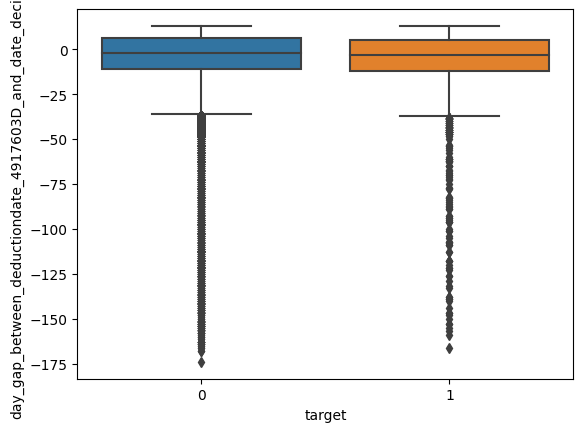

In [33]:
sns.boxplot(data=merged_train_base_statistics_deductiondate_4917603D_for_case_id_df, y="day_gap_between_deductiondate_4917603D_and_date_decision", x="target")

## Some tax deduction was done before date_decision and some after.  

In [34]:
merged_train_base_statistics_deductiondate_4917603D_for_case_id_df[~merged_train_base_statistics_deductiondate_4917603D_for_case_id_df.generated_deductiondate_4917603D_nunique.isnull()]["day_gap_between_deductiondate_4917603D_and_date_decision"].value_counts()

day_gap_between_deductiondate_4917603D_and_date_decision
 7.0      5938
 6.0      5394
 0.0      5328
 8.0      5295
 9.0      5106
          ... 
-168.0       2
-149.0       2
-165.0       2
-161.0       2
-174.0       1
Name: count, Length: 181, dtype: int64

### 2. amount_4917619A

In [35]:
get_column_description(feature_df, "amount_4917619A")

'Tax deductions amount tracked by the government registry.'

In [36]:
statistics_amount_4917619A_df = tax_registry_b_1_df.groupby(by=["case_id"]).agg({"amount_4917619A": ["max", "min", "mean"]}).reset_index()
statistics_amount_4917619A_df.columns  = ['case_id' if index_tuple[0] == 'case_id' else f"generated_{index_tuple[0]}_{index_tuple[1]}" for index_tuple in statistics_amount_4917619A_df.columns]

In [44]:
statistics_amount_4917619A_df.sort_values(by=["case_id"]).head()

,case_id,generated_amount_4917619A_max,generated_amount_4917619A_min,generated_amount_4917619A_mean
0,49435,6885.000,6885.0,6885.000000
1,49490,10834.601,8646.0,9322.900167
2,49526,30587.201,29855.0,30221.100500
3,49563,15467.800,780.8,7734.490936
4,49576,24300.000,4587.0,12518.636364


### 3. name_4917606M

In [40]:
get_column_description(feature_df, "name_4917606M")

'Name of employer.'

In [41]:
statistics_name_4917606M_for_case_id_df = tax_registry_b_1_df.groupby(by=["case_id"]).agg(generated_name_4917606M_nunique=pd.NamedAgg(column="name_4917606M", aggfunc="nunique"), generated_name_4917606M_mode=pd.NamedAgg(column="name_4917606M", aggfunc=lambda x:x.value_counts().index[0]))

In [42]:
statistics_name_4917606M_for_case_id_df

,generated_name_4917606M_nunique,generated_name_4917606M_mode
case_id,,
49435,1,6b730375
49490,1,6a3c1a8a
49526,1,926adc86
49563,1,9288fd65
49576,3,f4f3200b
...,...,...
2703443,1,6d3e6416
2703445,1,614a1950
2703448,1,ded265ee


In [38]:
statistics_amount_4917619A_df.shape

(150732, 4)

In [ ]:
(457934, 4)
